In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/nlp_learning/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: PASCAL_VOC/labels/2009_004290.txt  
  inflating: PASCAL_VOC/labels/2009_004291.txt  
  inflating: PASCAL_VOC/labels/2009_004295.txt  
  inflating: PASCAL_VOC/labels/2009_004298.txt  
  inflating: PASCAL_VOC/labels/2009_004300.txt  
  inflating: PASCAL_VOC/labels/2009_004301.txt  
  inflating: PASCAL_VOC/labels/2009_004303.txt  
  inflating: PASCAL_VOC/labels/2009_004307.txt  
  inflating: PASCAL_VOC/labels/2009_004308.txt  
  inflating: PASCAL_VOC/labels/2009_004309.txt  
  inflating: PASCAL_VOC/labels/2009_004312.txt  
  inflating: PASCAL_VOC/labels/2009_004315.txt  
  inflating: PASCAL_VOC/labels/2009_004316.txt  
  inflating: PASCAL_VOC/labels/2009_004317.txt  
  inflating: PASCAL_VOC/labels/2009_004319.txt  
  inflating: PASCAL_VOC/labels/2009_004322.txt  
  inflating: PASCAL_VOC/labels/2009_004323.txt  
  inflating: PASCAL_VOC/labels/2009_004324.txt  
  inflating: PASCAL_VOC/labels/2009_004327.txt  
  inflating: PASCA

In [4]:
import config
import torch
import torch.optim as optim

from model import YOLOv3
from tqdm import tqdm
from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)
from loss import YoloLoss
import warnings
warnings.filterwarnings("ignore")

In [5]:
def train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors, scheduler):
    loop = tqdm(train_loader, leave=True)
    losses = []
    for batch_idx, (x, y) in enumerate(loop):
        x = x.to(config.DEVICE)
        y0, y1, y2 = (
            y[0].to(config.DEVICE),
            y[1].to(config.DEVICE),
            y[2].to(config.DEVICE),
        )

        with torch.cuda.amp.autocast():
            out = model(x)
            loss = (
                loss_fn(out[0], y0, scaled_anchors[0])
                + loss_fn(out[1], y1, scaled_anchors[1])
                + loss_fn(out[2], y2, scaled_anchors[2])
            )

        losses.append(loss.item())
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        # update progress bar
        mean_loss = sum(losses) / len(losses)
        loop.set_postfix(loss=mean_loss)

In [6]:
model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
)
loss_fn = YoloLoss()
scaler = torch.cuda.amp.GradScaler()

train_loader, test_loader, train_eval_loader = get_loaders(
    train_csv_path=config.DATASET + "/train.csv", test_csv_path=config.DATASET + "/test.csv"
)

if config.LOAD_MODEL:
    load_checkpoint(
        config.CHECKPOINT_FILE, model, optimizer, config.LEARNING_RATE
    )


In [7]:
#!pip install torch_lr_finder

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.61E-02


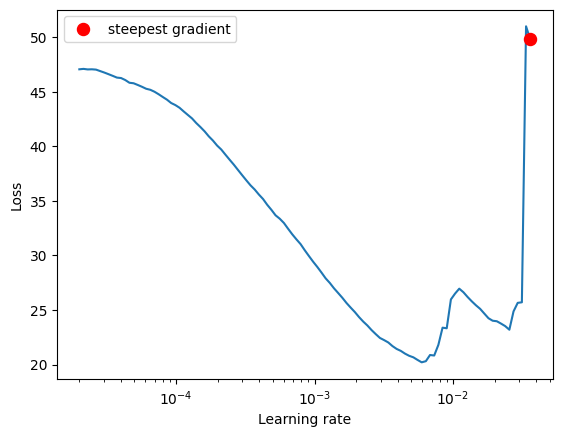

In [8]:
from torch_lr_finder import LRFinder
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)

def criterion(out, y):
    y0, y1, y2 = (
            y[0].to(config.DEVICE),
            y[1].to(config.DEVICE),
            y[2].to(config.DEVICE),
        )
    loss = (
                loss_fn(out[0], y0, scaled_anchors[0])
                + loss_fn(out[1], y1, scaled_anchors[1])
                + loss_fn(out[2], y2, scaled_anchors[2])
            )
    return loss
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

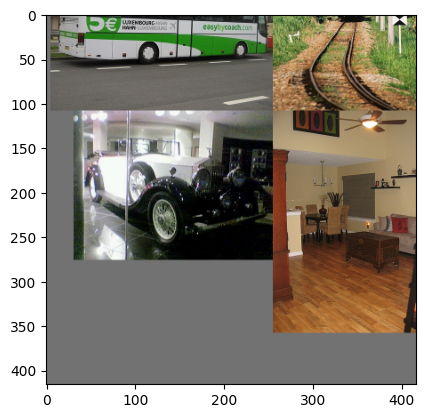

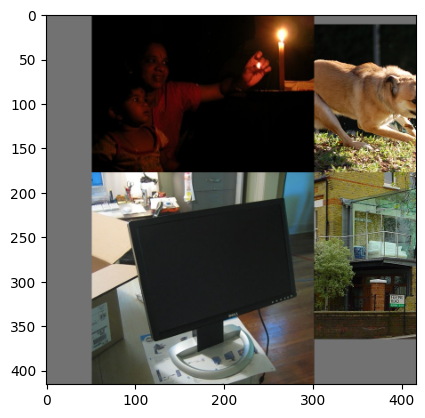

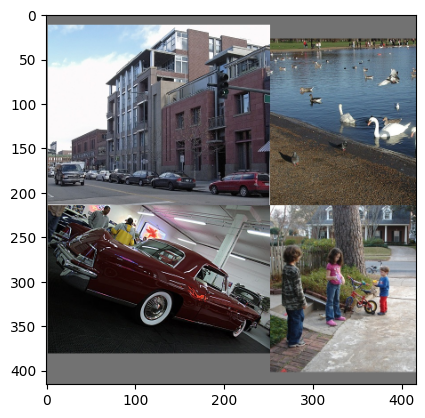

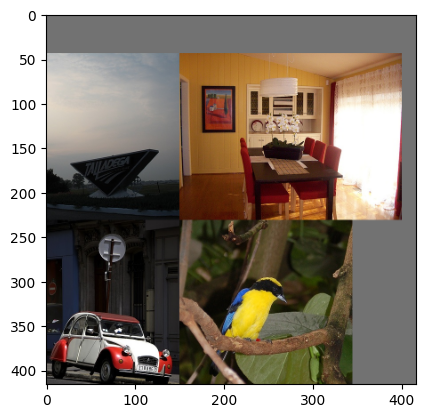

100%|██████████| 1035/1035 [16:53<00:00,  1.02it/s, loss=19.1]


=> Saving checkpoint
Currently epoch 0
On Train Eval loader:
On Train loader:


100%|██████████| 1035/1035 [14:00<00:00,  1.23it/s]


Class accuracy is: 33.999222%
No obj accuracy is: 99.585411%
Obj accuracy is: 2.361002%


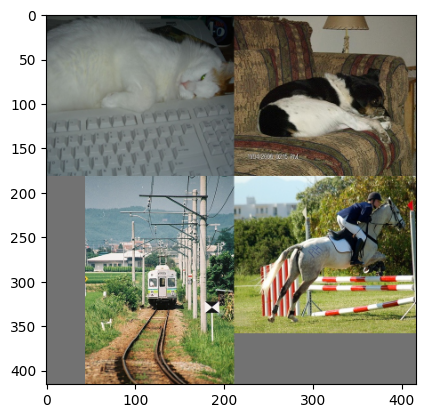

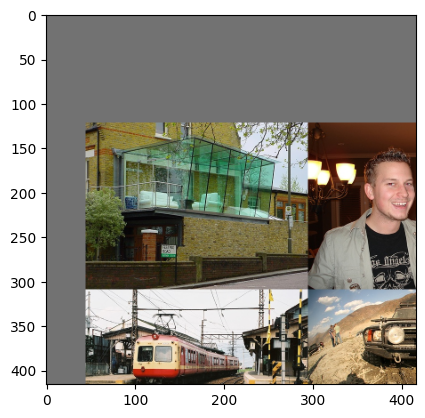

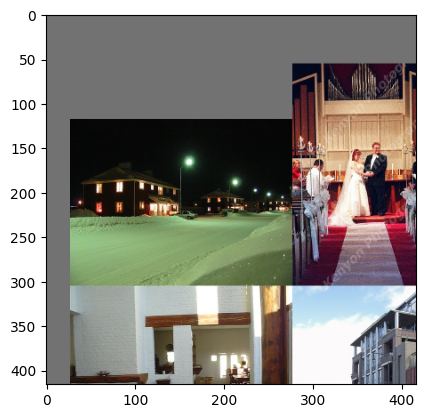

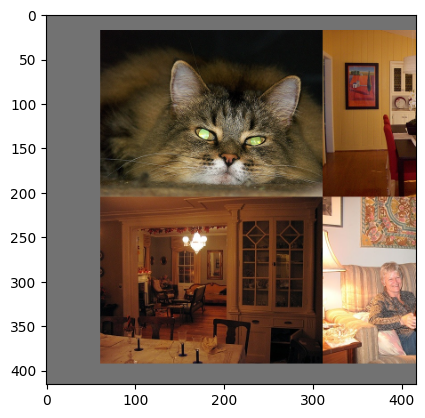

  2%|▏         | 23/1035 [00:21<15:22,  1.10it/s, loss=12.8]

In [ ]:
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)


from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = config.NUM_EPOCHS * 2 // 5
scheduler = OneCycleLR(
        optimizer,
        max_lr=1E-3,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

for epoch in range(EPOCHS):
    plot_couple_examples(model, test_loader, 0.6, 0.5, scaled_anchors)
    train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors, scheduler)

    if config.SAVE_MODEL:
       save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

    print(f"Currently epoch {epoch}")
    print("On Train Eval loader:")
    print("On Train loader:")
    check_class_accuracy(model, train_loader, threshold=config.CONF_THRESHOLD)

    if epoch > 0 and epoch % 3 == 0:
        check_class_accuracy(model, test_loader, threshold=config.CONF_THRESHOLD)
        pred_boxes, true_boxes = get_evaluation_bboxes(
            test_loader,
            model,
            iou_threshold=config.NMS_IOU_THRESH,
            anchors=config.ANCHORS,
            threshold=config.CONF_THRESHOLD,
        )
        mapval = mean_average_precision(
            pred_boxes,
            true_boxes,
            iou_threshold=config.MAP_IOU_THRESH,
            box_format="midpoint",
            num_classes=config.NUM_CLASSES,
        )
        print(f"MAP: {mapval.item()}")
        model.train()

In [ ]:
lr_finder.reset()
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)


from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = config.NUM_EPOCHS // 5
scheduler = OneCycleLR(
        optimizer,
        max_lr=1E-3,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

for epoch in range(EPOCHS):
    plot_couple_examples(model, test_loader, 0.6, 0.5, scaled_anchors)
    train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors, scheduler)

    if config.SAVE_MODEL:
       save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

    print(f"Currently epoch {epoch}")
    print("On Train Eval loader:")
    print("On Train loader:")
    check_class_accuracy(model, train_loader, threshold=config.CONF_THRESHOLD)

    if epoch > 0 and epoch % 3 == 0:
        check_class_accuracy(model, test_loader, threshold=config.CONF_THRESHOLD)
        pred_boxes, true_boxes = get_evaluation_bboxes(
            test_loader,
            model,
            iou_threshold=config.NMS_IOU_THRESH,
            anchors=config.ANCHORS,
            threshold=config.CONF_THRESHOLD,
        )
        mapval = mean_average_precision(
            pred_boxes,
            true_boxes,
            iou_threshold=config.MAP_IOU_THRESH,
            box_format="midpoint",
            num_classes=config.NUM_CLASSES,
        )
        print(f"MAP: {mapval.item()}")
        model.train()